In [1]:
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
from scipy.stats import expon, skewnorm, norm

import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import shotchartdetail, playercareerstats, playergamelog

import ballDontLie 
from ballDontLie.util.api_nba import find_player_id
from ballDontLie.util.fantasy import compute_fantasy_points

In [2]:
seasons_range = ['2018-19', '2017-18', '2016-17', '2015-16']
players_range = ['Anthony Davis', 'James Harden', 'Stephen Curry', 'Giannis Antetokounmpo', 'Karl-Anthony Towns',
                'Nikola Jokic', 'Joel Embiid', 'Paul George', 'Kawhi Leonard', 'Damian Lillard', 'Jimmy Butler',
                'LeBron James', "Bradley Beal"]
player_id_map = {a: find_player_id(a) for a in players_range}

For the various players and the various seasons, let's look at the distributions of some of their box stats

/Users/ayang41/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


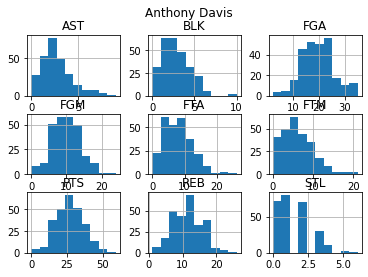

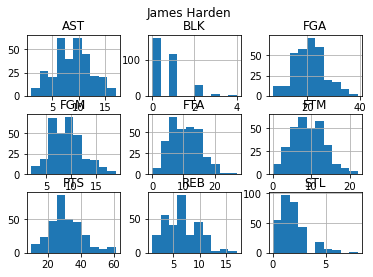

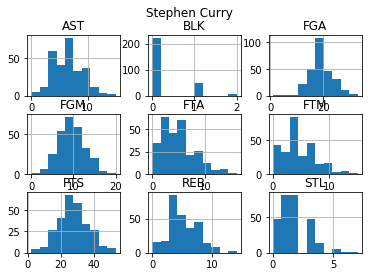

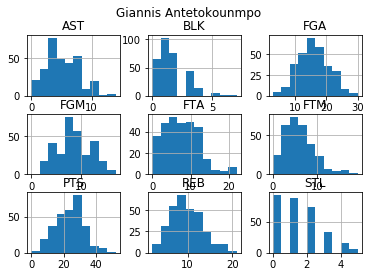

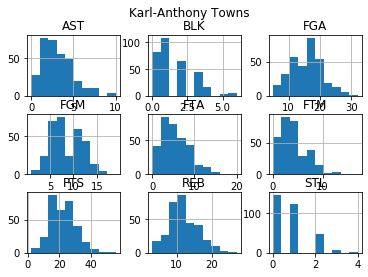

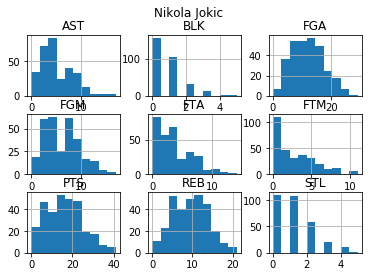

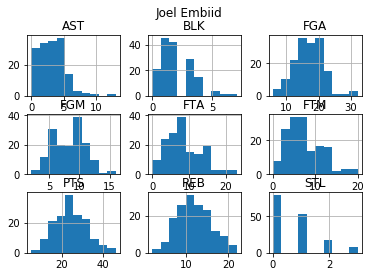

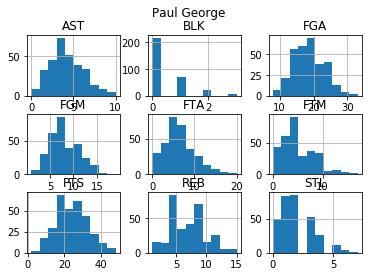

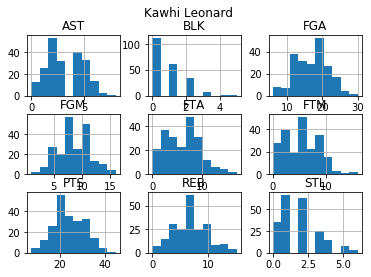

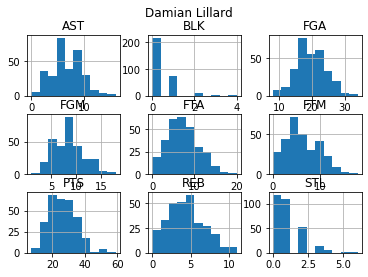

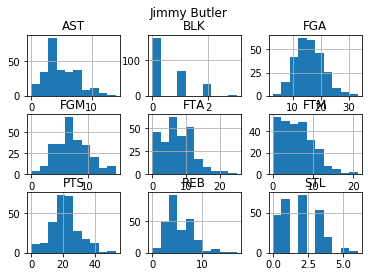

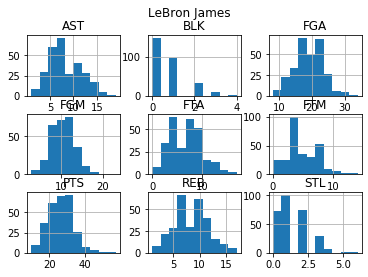

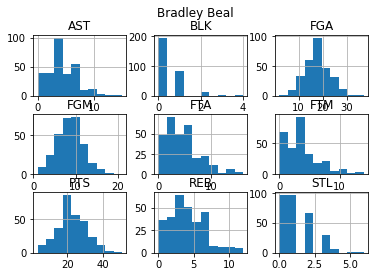

In [3]:
for player, player_id in player_id_map.items():
    fig, ax = plt.subplots(1,1)
    df = pd.read_csv('data/{}.csv'.format(player.replace(" ","")))
    df.hist(column=['FGM', 'FGA', 'FTM', 'FTA', "REB", 'AST',
                     'STL', 'BLK', "PTS"], ax=ax)
    fig.suptitle(player)
                     

I'm going off by what these distributions sort of look like over all the players:
* AST: Skewed normal
* BLK: Exponential
* FGA: Normal
* FGM: Normal
* FTA: Skewed normal
* FTM: Skewed normal
* PTS: Normal
* REB: Skewed normal
* STL: Skewed normal

For all players, I'm going to model each box stat as such. Given the gamelog data (blue), fit the model to that data, 
generate some values with that model (orange), and compare to the actual gamelog data.

Some comments:

For the "bigger" numbers like PTS, FGA, FGM, REB, the model distributions fit pretty well. 

For the "smaller" numbers like BLK or STL (a player will usually have 0, 1, 2, 3, or maybe 4 of that stat) - these numbers are more discrete than the "bigger numbers". If you can score points between 0 and 40, each actually reported points behaves more continuously since there is more variety.

From earlier work with PyMC for Bayesian probability modeling, I could have tried using PyMC to sample parameters for each stat-distribution, rather than just do a singular fitting. While that could help report a variety of parameters for each stat-distribution in addition to a sense of variation or uncertainty, I don't think it's super necessary to really venture into exploring the different distributions and their parameters that could fit each box stat; the fitting schemes via scipy seem to work well.

It's possible there are better models to fit some of the data - I can't say my brain-database of statistical models is extensive, so I just kinda perused through `scipy.stats`.

Fitting a distribution helps formalize how much a player's game can vary (is he consistently a 20ppg player? Or are is he hot and cold between 10 and 30 ppg?) Furthermore, if a player is out (injured or some other reason), that implicitly gets captured by a gamelog of 0pts, 0reb, etc. This is definitely important in fantasy because some may value a more reliable/consistent player who will show up to 80/82 games rather than a glass weapon who could drop 50 points, but will only play 40-50/82 games

These distributions assume we can ignore: coaching changes, team roster changes, and maybe player development. For player development, a younger player between 2015-2019 will demonstrate huge variance in two ways - young players are inconsistent game-to-game, but young players can also develop rapidly season-by-season. At the very least, these distributions try to describe variance, which shows room where a young player could go off or bust on a given night. Factoring season-by-season improvement will be hard - one would need to try to forecast a player's future stats rather than draw samples from a "fixed" distribution based on previous stats

In [4]:
stat_model_map = {"AST": skewnorm, "BLK": expon, "FGA": norm, "FGM": norm,
                 "FTA": skewnorm, "FTM": skewnorm, "PTS": norm, "REB": skewnorm,
                 "STL": skewnorm}

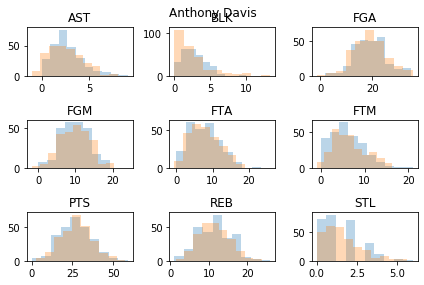

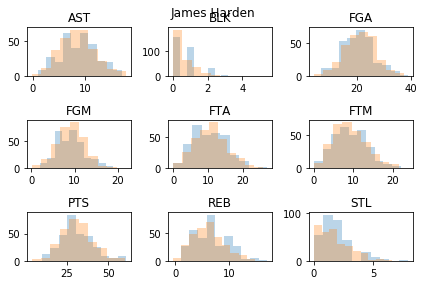

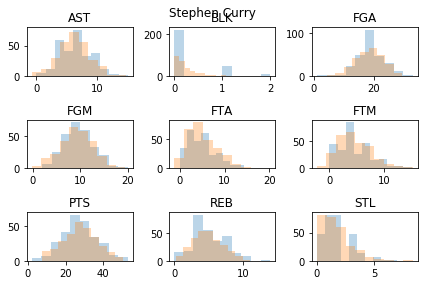

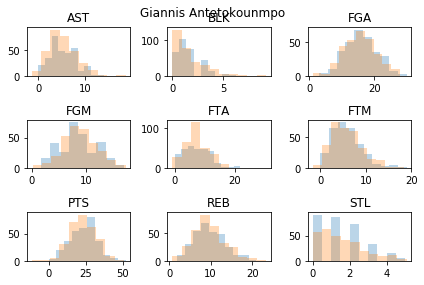

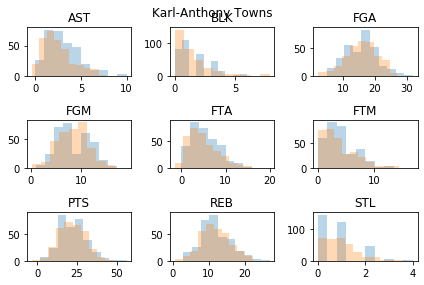

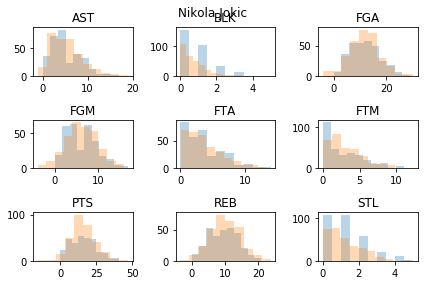

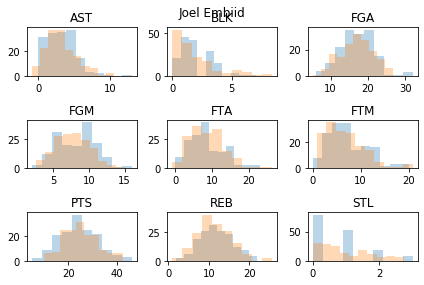

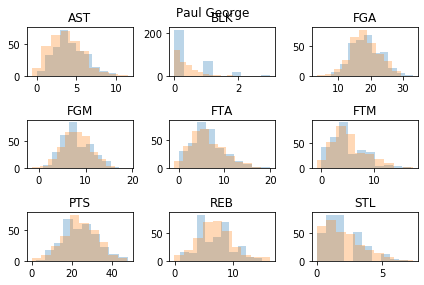

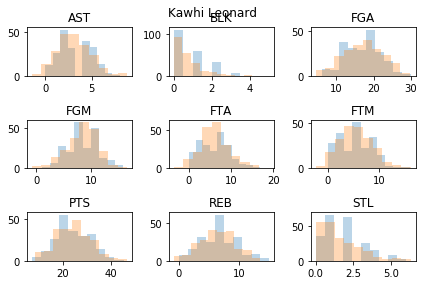

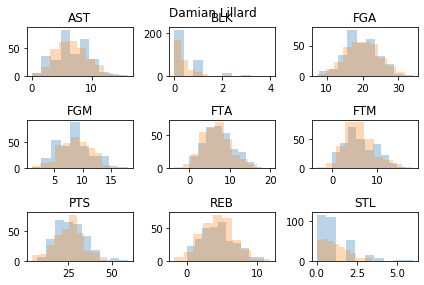

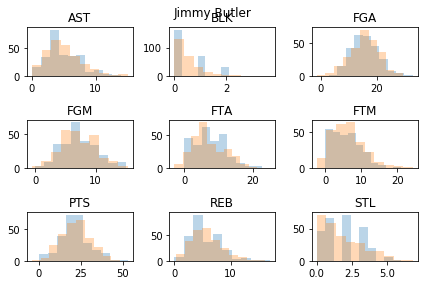

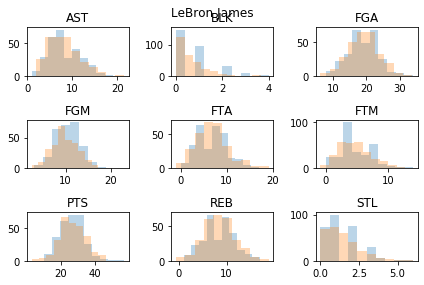

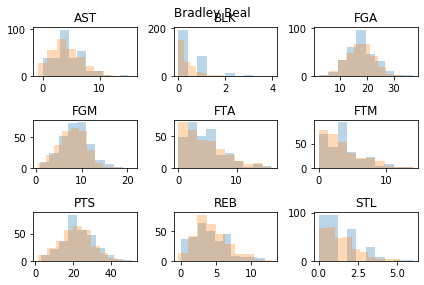

In [5]:
for player, player_id in player_id_map.items():
    fig, axarray = plt.subplots(3,3)
    df = pd.read_csv('data/{}.csv'.format(player.replace(" ","")))
    for i, (stat, model) in enumerate(stat_model_map.items()):
        row = i // 3
        col = i % 3
        axarray[row, col].hist(df[stat], alpha=0.3)
        axarray[row, col].set_title(stat)
        params = model.fit(df[stat])
        axarray[row, col].hist(model.rvs(*params, size=len(df[stat])), alpha=0.3)

    
    
    fig.suptitle(player)
    fig.tight_layout()
                     

At this point, for each player and box stat, we have a distribution that can describe their game-by-game performance. Maybe we can sample from this distribution 82 times (82 games per season) to get an idea of the fantasy points they'll yield (the fantasy points will depend on the league settings and how each league weights the box stats).

To simulate a season for a player, we will model the distribution for each box stat, and sample from it 82 times. This is our simulated season.

In [6]:
simulated_season = pd.DataFrame()
for player, player_id in player_id_map.items():
    df = pd.read_csv('data/{}.csv'.format(player.replace(" ","")))
    simulated_player_log = {}
    for stat, model in stat_model_map.items():
        params = model.fit(df[stat])
        sample = model.rvs(*params, size=82)
        simulated_player_log[stat] = sample
    simulated_player_log_series = pd.Series(data=simulated_player_log, name=player)
    simulated_season = simulated_season.append(simulated_player_log_series)

In addition to getting an 82-list of ast, blk, fga, etc. We can compute an 82-list of fantasy points (point values will depend on the league, but the default args for `compute_fantasy_points` are pulled from ESPN head-to-head points league default categories

In [7]:
simulated_season = compute_fantasy_points(simulated_season)
simulated_season

,AST,BLK,FGA,FGM,FTA,FTM,PTS,REB,STL,FP
Anthony Davis,"[5.9597699533362665, 3.218551371084111, 1.1022...","[8.578394640988105, 0.026198088049728254, 1.84...","[20.21599540596214, 19.100646432695086, 26.528...","[13.872698337473729, 7.918853515554012, 9.5048...","[14.873567185676178, 9.685624594656804, 10.241...","[1.0995020882840587, 7.294623211426735, 7.2877...","[30.67865219506473, 15.260082139070928, 17.769...","[13.498196895282199, 5.04028872591627, 16.2989...","[1.1347148361527453, 1.7312487922029391, 1.068...","[39.732366354943515, 11.703574815952832, 18.10..."
James Harden,"[6.725125502991835, 16.337635303737578, 8.6225...","[0.05211498826964095, 0.5114333703840529, 0.08...","[31.451667457570714, 15.992361996925819, 19.37...","[9.307080381863589, 8.033940758354536, 11.1817...","[12.808604943217352, 12.428544803014987, 11.82...","[-0.06498946030802255, 8.515864278527303, 3.23...","[20.97714144699512, 32.02286792578204, 22.5610...","[6.9093167207067765, 7.988699867679405, 5.5192...","[0.32632320180968244, 0.6531429770923043, 2.89...","[-0.0281596184594477, 45.64267768161641, 22.89..."
Stephen Curry,"[12.279924280581394, 7.879981071011731, 5.9023...","[0.06292945230558766, 0.09033987679766506, 0.1...","[28.850986709915357, 24.43691542042258, 17.400...","[12.472086572331825, 9.555215666190444, 8.2599...","[12.977887030692326, 3.1789263709957845, -0.86...","[-0.010198935847337554, 3.516792829956679, 6.6...","[32.67407066270164, 24.97462588841426, 29.3427...","[3.9327364866510104, 7.6111446721103615, 4.726...","[3.590539393208442, 1.7898067047882282, 2.1206...","[23.173214171324872, 27.802064917851006, 40.60..."
Giannis Antetokounmpo,"[0.028588769334945585, 3.262013551923701, 3.40...","[1.9174837837589362, 6.695156990323455, 0.2378...","[7.172387181137829, 15.12244530666314, 20.4210...","[10.4727740339432, 16.131669525478472, 9.71417...","[11.746787857935951, 5.523726797994956, 15.646...","[8.191304596222707, 1.8995774627238957, 9.6062...","[38.321060006893674, 17.906593672693283, 7.885...","[19.219901699676136, 9.067580346050558, 9.3800...","[0.19042746270131458, 0.8734312501637576, 1.68...","[59.422365313457135, 35.189850694699025, 5.842..."
Karl-Anthony Towns,"[4.2665586948098095, 2.239352382015603, 2.8486...","[1.5142034413304508, 0.5455258265042157, 0.238...","[16.282437483033767, 16.64803799271481, 15.635...","[6.438364846075592, 9.772816680970095, 12.7305...","[-0.7312367428381779, 8.855766357633657, 7.839...","[12.274313450703058, 3.407774443197603, 1.1792...","[39.024821580722396, 18.827116373850785, 6.703...","[13.494959487083559, 6.618974662978514, 13.515...","[1.1278422771833472, 0.969599487392581, 1.1214...","[62.589863037712625, 16.87735550656093, 14.862..."
Nikola Jokic,"[2.2495283329958697, 4.313187987247313, 13.591...","[0.12814150793734586, 1.0322534945133215, 0.22...","[15.985739566133859, 3.729397368467904, 13.122...","[2.2695563355573927, 4.6162142202699465, 12.37...","[1.140250956051838, 0.7396592852362885, 1.0218...","[1.728722802038216, 4.521343806420914, 2.80787...","[18.321586322668246, 14.595347285061017, 36.97...","[12.219234056488448, 6.129650356878898, 10.120...","[0.46503541814884397, 2.3095400747975847, 4.42...","[20.255814253648666, 33.0484805714848, 66.3739..."
Joel Embiid,"[-0.5626100721097174, 6.31861993131192, 2.4004...","[3.745530342633801, 1.2329342353392367, 0.6703...","[23.858670698530716, 14.171117481078998, 22.38...","[8.531705694178644, 6.592226230945353, 5.78683...","[3.636279316429121, 10.099346265562726, 5.7510...","[5.614085976697099, 10.835254446544083, 10.530...","[21.316896006823455, 37.63500403364662, 15.459...","[11.773784732117047, 12.398188556975562, 7.601...","[0.5668458333098912, 0.5312890917217526, 0.310...","[23.491288498690384, 51.2730527798428, 14.6226..."
Paul George,"[3.747746441549796, 1.4181358595970992, 5.9393...","[0.1381904316955113, 1.0488620581494552, 0.056...","[11.961150191031587, 21.844008115116335, 28.35...","[8.270970012797578, 10.471683200512018, 8.65

To make things simpler to read, we will compress the dataframe into totals for the entire season, including
the total fantasy points for that season

In [8]:
simulated_totals = simulated_season.copy()
for col in simulated_totals.columns:
    simulated_totals[col] = [sum(a) for a in simulated_totals[col]]
simulated_totals.sort_values('FP', ascending=False)

,AST,BLK,FGA,FGM,FTA,FTM,PTS,REB,STL,FP
James Harden,747.830702,50.407450,1762.218494,767.004764,864.891220,728.555527,2578.629298,554.455532,138.349447,2938.123005
LeBron James,644.902311,53.848741,1528.397672,867.848033,535.034764,397.555538,2299.442187,621.522299,111.886953,2933.573626
Giannis Antetokounmpo,411.042856,113.488274,1307.959350,724.625241,567.077934,473.292758,2117.891129,777.568640,99.125458,2841.997073
Stephen Curry,506.145110,24.894564,1409.398642,773.939875,380.741190,329.111538,2362.073947,420.829387,137.321349,2764.175938
Karl-Anthony Towns,205.572031,131.434058,1226.963594,778.868996,426.204892,330.018614,1801.931600,946.156019,79.285543,2620.098373
Anthony Davis,196.578860,175.150824,1622.873347,816.723251,696.171419,456.367971,2260.519240,900.291765,124.250201,2610.837347
Joel Embiid,234.186200,163.287594,1435.194243,660.241425,734.381531,582.971875,2023.816505,1017.135889,65.729671,2577.793384
Kawhi Leonard,254.481192,58.379376,1429.088809,694.413700,508.884724,464.766005,1988.136387,495.686852,164.975375,2182.865355
Damian Lillard,517.704615,22.305801,1532.940857,714.316068,628.611949,519.754053,2133.813013,339.602730,96.813527,2182.757000
Jimmy Butler,413.035473,38.031837,1281.235832,606.988700,589.880982,492.461756,1824.943569,467.421917,151.978400,2123.744838


Generally speaking, this method is in-line with many other fantasy predictions. James Harden, Anthony Davis, 
LeBron James, Karl-Anthony Towns, Steph Curry, Giannis, and Joel Embiid all top the list. 

In this "simulation" our sample size was 82 to match a season. We could repeat this simulation multiple times (so 82 * n times). That effectively increases our sample size from 82 to much larger.

Sampling enough is always a question, so we'll address that by simulating multiple seasons. Discussion of the approach will follow later

In [9]:
def simulate_n_seasons(player_id_map, stat_model_map, n=5):
    # For a season, we just want the player, FP, and the rank
    # Initialize dictionary of dictionary of lists to store this information across "epochs"
    epoch_results = {}
    for player in player_id_map:
        epoch_results[player] = {'FP':[], 'rank':[]}
        
    for i in range(n):
        # Just copy-pasted code for convenience in a notebook
        # If this were a python script, I would probably put these functions in a module/library somewhere
        # Model the distribution of a player's box stats, simulate 82 times, compute fantasy points
        simulated_season = pd.DataFrame()
        for player, player_id in player_id_map.items():
            df = pd.read_csv('data/{}.csv'.format(player.replace(" ","")))
            simulated_player_log = {}
            for stat, model in stat_model_map.items():
                params = model.fit(df[stat])
                sample = model.rvs(*params, size=82)
                simulated_player_log[stat] = sample
            simulated_player_log_series = pd.Series(data=simulated_player_log, name=player)
            simulated_season = simulated_season.append(simulated_player_log_series)
        simulated_season = compute_fantasy_points(simulated_season)
        simulated_totals = simulated_season.copy()
        for col in simulated_totals.columns:
            simulated_totals[col] = [sum(a) for a in simulated_totals[col]]
        simulated_totals = simulated_totals.sort_values('FP', ascending=False)


        # Store the fantasy points and player rank for that simulated season
        for player in player_id_map:
            epoch_results[player]['FP'].append(simulated_totals[simulated_totals.index==player]['FP'].values[0])
            epoch_results[player]['rank'].append(simulated_totals.index.get_loc(player))
    return epoch_results

epoch_results = simulate_n_seasons(player_id_map, stat_model_map, n=10)

In [10]:
pprint(epoch_results)

{'Anthony Davis': {'FP': [2600.2718925173745,
                          2845.699762026843,
                          2732.8142372134657,
                          2841.1189014237507,
                          2971.6018500231144,
                          2513.4197141216027,
                          2671.907808833641,
                          2771.33344794354,
                          2642.4401320506413,
                          2668.8391100382087],
                   'rank': [3, 0, 2, 1, 0, 5, 2, 2, 2, 3]},
 'Bradley Beal': {'FP': [2017.9614666080413,
                         1898.010517178849,
                         1804.7941022033058,
                         1763.042431335895,
                         1730.5132495765397,
                         1715.734094440131,
                         1838.502289868321,
                         1867.0678145772936,
                         1718.2489707303305,
                         1669.67185265485],
                  'rank': [11, 12, 12,

To make things prettier, we can just summarize the player ranks over all the simulated seasons, providing us an estimated average rank and error

In [11]:
def summarize_epoch_results(epoch_results):
    summary_stats = {}
    for player in epoch_results:
        summary_stats[player] = {}
        avg_rank = np.mean(epoch_results[player]['rank'])
        std_rank = np.std(epoch_results[player]['rank'])
        summary_stats[player]['rank'] = avg_rank
        summary_stats[player]['err'] = std_rank
    return summary_stats

summary_stats = summarize_epoch_results(epoch_results)
sorted(summary_stats.items(), key=lambda v: v[1]['rank'])

[('James Harden', {'rank': 0.3, 'err': 0.45825756949558394}),
 ('LeBron James', {'rank': 1.4, 'err': 0.8}),
 ('Anthony Davis', {'rank': 2.0, 'err': 1.4142135623730951}),
 ('Joel Embiid', {'rank': 3.9, 'err': 1.3}),
 ('Giannis Antetokounmpo', {'rank': 4.1, 'err': 1.3}),
 ('Karl-Anthony Towns', {'rank': 4.2, 'err': 1.5362291495737217}),
 ('Stephen Curry', {'rank': 5.3, 'err': 1.1}),
 ('Kawhi Leonard', {'rank': 8.0, 'err': 1.0954451150103321}),
 ('Damian Lillard', {'rank': 8.3, 'err': 1.4177446878757827}),
 ('Nikola Jokic', {'rank': 8.4, 'err': 1.2}),
 ('Paul George', {'rank': 9.7, 'err': 1.1}),
 ('Jimmy Butler', {'rank': 10.5, 'err': 1.02469507659596}),
 ('Bradley Beal', {'rank': 11.9, 'err': 0.3})]

# Observations (based on this approach)
Harden, LeBron, and AD are a cut above the rest. Beal is not looking too hot

# Room for improvement
* Is building a distribution from year 2015-onward a good idea?
* Pick better models to represent the distribution of a player's box stats?
* How do we account for player development? Forecasting player stats, not just modeling
* How do we account for roster/team changes?
* Can we account for hot streaks for a player?
* Is there a more robust way to deal with player injury rather than hoping for 0/0/0 in the gamelogs?
* Correlation between stats? If a player is on, they might end up playing better overall
* Can we try to time schedules? I.e. some NBA players will have 4-game weeks, can a corresponding fantasy player use that based on the fantasy schedule and truly trying to beat your fantasy opponent? 
* Is there a need to draft a player in reaction to other fantasy player draftpicks? This may depend on how specific your team roles have to be. If team roles are lax, then choose the best fantasy option. If you need to fill out a roster, then you have to start weighing your roster choices vs what opponents may end up drafting